In [1]:
import tensorflow as tf
import keras
print(tf.__version__)

2.10.0


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm

# Model

In [4]:
# Encoder Utilities

def conv2d_block(input_tensor, n_filters, kernel_size = 3):
    '''
    Adds 2 convolutional layers with the parameters passed to it

    Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

    Returns:
    tensor of output features
    '''
    # first layer
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
                kernel_initializer = 'he_normal', padding = 'same')(x)
        x = tf.keras.layers.Activation('relu')(x)

    return x


def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
    '''
    Adds two convolutional blocks and then perform down sampling on output of convolutions.

    Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

    Returns:
    f - the output features of the convolution block 
    p - the maxpooled features with dropout
    '''

    f = conv2d_block(inputs, n_filters=n_filters)
    p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
    p = tf.keras.layers.Dropout(0.3)(p)

    return f, p


def encoder(inputs):
    '''
    This function defines the encoder or downsampling path.

    Args:
    inputs (tensor) -- batch of input images

    Returns:
    p4 - the output maxpooled features of the last encoder block
    (f1, f2, f3, f4) - the output features of all the encoder blocks
    '''
    f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
    f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
    f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
    f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

    return p4, (f1, f2, f3, f4)


In [5]:
def bottleneck(inputs):
    '''
    This function defines the bottleneck convolutions to extract more features before the upsampling layers.
    '''

    bottle_neck = conv2d_block(inputs, n_filters=1024)

    return bottle_neck

In [6]:
# Decoder Utilities

def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
    '''
    defines the one decoder block of the UNet

    Args:
    inputs (tensor) -- batch of input features
    conv_output (tensor) -- features from an encoder block
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size
    strides (int) -- strides for the deconvolution/upsampling
    padding (string) -- "same" or "valid", tells if shape will be preserved by zero padding

    Returns:
    c (tensor) -- output features of the decoder block
    '''
    u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
    c = tf.keras.layers.concatenate([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filters, kernel_size=3)

    return c

def decoder_binary(inputs, convs, output_channels):
    '''
    Defines the decoder of the UNet chaining together 4 decoder blocks. 

    Args:
    inputs (tensor) -- batch of input features
    convs (tuple) -- features from the encoder blocks
    output_channels (int) -- number of classes in the label map

    Returns:
    outputs (tensor) -- the pixel wise label map of the image
    '''

    f1, f2, f3, f4 = convs

    c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    return outputs

def decoder_reg(inputs, convs, output_channels):
    '''
    Defines the decoder of the UNet chaining together 4 decoder blocks. 

    Args:
    inputs (tensor) -- batch of input features
    convs (tuple) -- features from the encoder blocks
    output_channels (int) -- number of classes in the label map

    Returns:
    outputs (tensor) -- the pixel wise label map of the image
    '''

    f1, f2, f3, f4 = convs

    c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='linear')(c9)

    return outputs

In [7]:
OUTPUT_CHANNELS = 1

def unet():
    '''
    Defines the UNet by connecting the encoder, bottleneck and decoder.
    '''

    # specify the input shape
    inputs = tf.keras.layers.Input(shape=(512, 512,1,))

    # feed the inputs to the encoder
    encoder_output, convs = encoder(inputs)

    # feed the encoder output to the bottleneck
    bottle_neck = bottleneck(encoder_output)

    # feed the bottleneck and encoder block outputs to the decoder
    # specify the number of classes via the `output_channels` argument
    output_bin = decoder_binary(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)

    output_reg = decoder_reg(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)


    # create the model
    model = tf.keras.Model(inputs=inputs, outputs=[output_bin,output_reg])

    return model

# instantiate the model
model = unet()

# see the resulting model architecture
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 512, 512, 64  0           ['conv2d[0][0]']                 
                                )                                                             

# Data Loader

In [9]:
train_path = '/home/caki/desktop/projects/unet/unet-tf/rose2/train'
val_path = '/home/caki/desktop/projects/unet/unet-tf/rose2/test'

In [10]:
image_ext = ['.png','.jpg']
def natural_sort(l):
    def convert(text): return int(text) if text.isdigit() else text.lower()
    def alphanum_key(key): return [convert(c)
                                   for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

def get_image_list(path):
    image_names = []
    for maindir, subdir, file_name_list in os.walk(path):
        for filename in file_name_list:
            if '_label' not in filename:
                apath = os.path.join(maindir, filename)
                ext = os.path.splitext(apath)[1]
                if ext in image_ext:
                    image_names.append(apath)
    return natural_sort(image_names)

In [11]:
train_images = get_image_list(train_path)
val_images = get_image_list(val_path)

In [12]:
print(len(train_images))
print(len(val_images))

90
22


In [19]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, image_list, input_size, batch_size, aug_rate, debug=False, augmentor=None):
        self.image_list = image_list
        print("Data Length: {}".format(len(self.image_list)))
        self.input_height = input_size[0]
        self.input_width = input_size[1]
        self.input_channel = input_size[2]

        self.batch_size = batch_size
        self.augmentor = augmentor
        self.aug_rate = aug_rate
        self.on_epoch_end()
        self.debug_images = debug
    def __len__(self):
        #'the number of batches(iteration) per epoch'
        return int(np.floor(len(self.image_list) / self.batch_size))

    # method that is called after every epoch. 
    # We can add routines like shuffling here.
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_list))
        np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        # select data and load images
        masks_dist = []
        masks_bin = []
        images = []

        for k in indexes:
            
            #read image
            image = cv2.resize(cv2.imread(
                self.image_list[k],0), (self.input_height, self.input_width))
            image = np.expand_dims(image, axis=-1)
            
            #read label mask
            mask_path = self.image_list[k][:self.image_list[k].rfind('.')] + '_label.png'
            mask_bin = cv2.resize(cv2.imread(mask_path, 0), (self.input_height, self.input_width))

            
            mask_path = self.image_list[k][:self.image_list[k].rfind('.')] + '_dist_label.png'
            mask_dist = cv2.resize(cv2.imread(mask_path, 0), (self.input_height, self.input_width))
            # mask = np.expand_dims(mask, axis=-1)
            
            #preprocess image
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image.astype("float32")/255.
            #image = (image - image.mean())/image.std()

            
            #preprocess mask
            mask_dist = mask_dist.astype("float32") / 255. 
            mask_dist = np.expand_dims(mask_dist,axis=-1)
            
            mask_bin = mask_bin.astype("float32") / 255. 
            mask_bin = np.expand_dims(mask_bin,axis=-1)
            
            #multiclass classificatin
            #mask = mask - 1
            #mask_one_hot = np.zeros((mask.shape[0], mask.shape[1], 4))
            #for i, unique_value in enumerate(np.unique(mask)):
            #    mask_one_hot[:, :, i][mask == unique_value] = 1
            
            masks_dist.append(mask_dist)
            masks_bin.append(mask_bin)

            images.append(image)
        
        
        if self.debug_images:
            if not os.path.exists(debug_input):
                os.mkdir(debug_input)
            for c,image in enumerate(images):
                cv2.imwrite("debug_input/"+str(c)+"_org.jpg", image)
        
        # augment data
        if (self.augmentor and np.random.random()<self.aug_rate):
            images, masks = self.augmentor(images, masks)


        if (self.augmentor and np.random.random()<self.aug_rate) and self.debug_images:
            for c,image in enumerate(images):
                cv2.imwrite("Aug Debug/"+str(c)+"_aug.jpg", image)
            
            sys.exit(0)

        if self.debug_images:
            sys.exit(0)
        images = np.array(images, dtype=np.float32)
        masks_bin = np.array(masks_bin, dtype=np.uint8)
        masks_dist = np.array(masks_dist, dtype=np.float32)

        return images, [masks_bin, masks_dist]

In [20]:
BATCH_SIZE = 1
train_gen = DataGenerator(
    train_images, (512,512,1), BATCH_SIZE, 0)

Data Length: 90


In [21]:
val_gen = DataGenerator(
    val_images, (512,512,1), BATCH_SIZE, 0)

Data Length: 22


In [22]:
def display(display_list,titles=[], display_string=None):
    '''displays a list of images/masks'''

    plt.figure(figsize=(15, 15))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
        if display_string and i == 1:
            plt.xlabel(display_string, fontsize=12)
        img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
        plt.imshow(img_arr)

    plt.show()


def show_image_from_dataset(train_gen):
    '''displays the first image and its mask from a dataset'''

    for image, mask in dataset.take(1):
        sample_image, sample_mask = image, mask
    display([sample_image, sample_mask], titles=["Image", "True Mask"])

(1, 512, 512, 1) (1, 512, 512, 1) (1, 512, 512, 1)


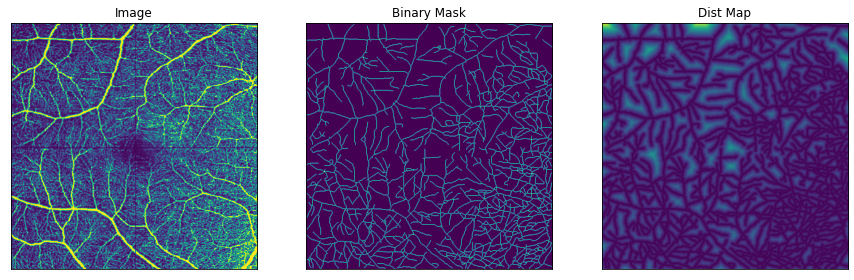

IndexError: index 1 is out of bounds for axis 0 with size 1

In [26]:
for x, y in train_gen:
    print(x.shape, y[0].shape,y[1].shape)
    for i in range(4):
        display([x[i],y[0][i],y[1][i]], titles=["Image", "Binary Mask",'Dist Map'])
    break

# Loss

In [28]:
from tensorflow.keras.losses import binary_crossentropy, MeanSquaredError
def _dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))
    return tf.reshape(1 - numerator / denominator, (-1, 1, 1))

def CEDLLoss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + _dice_loss(y_true, y_pred)

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=[CEDLLoss,'mean_squared_error'])

In [30]:
model_save_dir = '/home/caki/desktop/projects/unet/unet-tf/savedir'
checkpoint = ModelCheckpoint(os.path.join(model_save_dir, "{epoch:02d}-{val_loss:.4f}.h5"), save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)

# Train

In [31]:
TRAIN_LENGTH = len(train_images)
EPOCHS = 50
VAL_SUBSPLITS = 1
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = len(val_images)//BATCH_SIZE//VAL_SUBSPLITS

# this will take around 20 minutes to run
model_history = model.fit(train_gen, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_gen,
                         callbacks=[checkpoint])

Epoch 1/50
90/90 [==============================] - 178s 1s/step - loss: 1.3225 - conv2d_18_loss: 1.2359 - conv2d_27_loss: 0.0867 - val_loss: 1.0438 - val_conv2d_18_loss: 1.0421 - val_conv2d_27_loss: 0.0017
Epoch 2/50
90/90 [==============================] - 134s 1s/step - loss: 1.0375 - conv2d_18_loss: 1.0353 - conv2d_27_loss: 0.0022 - val_loss: 0.9674 - val_conv2d_18_loss: 0.9659 - val_conv2d_27_loss: 0.0014
Epoch 3/50
90/90 [==============================] - 132s 1s/step - loss: 1.0041 - conv2d_18_loss: 1.0021 - conv2d_27_loss: 0.0019 - val_loss: 0.9999 - val_conv2d_18_loss: 0.9985 - val_conv2d_27_loss: 0.0014
Epoch 4/50
90/90 [==============================] - 132s 1s/step - loss: 0.9850 - conv2d_18_loss: 0.9831 - conv2d_27_loss: 0.0018 - val_loss: 0.9188 - val_conv2d_18_loss: 0.9175 - val_conv2d_27_loss: 0.0013
Epoch 5/50
90/90 [==============================] - 132s 1s/step - loss: 0.9731 - conv2d_18_loss: 0.9713 - conv2d_27_loss: 0.0018 - val_loss: 0.9317 - val_conv2d_18_loss: 0

KeyboardInterrupt: 

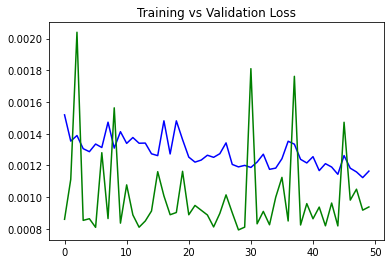

In [55]:
def plot_metrics(metric_name, title):
    '''plots a given metric from the model history'''
    plt.title(title)
    #plt.ylim(ylim)
    plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
    plt.plot(model_history.history['val_' + metric_name],color='green',label='val_' + metric_name)
plot_metrics("loss", title="Training vs Validation Loss")

In [32]:
model.load_weights('savedir/19-0.8746.h5')

In [33]:
def class_wise_metrics(y_true, y_pred,num_of_class):
    class_wise_iou = []
    class_wise_dice_score = []

    smoothening_factor = 0.00001

    for i in range(num_of_class):

        intersection = np.sum((y_pred == i) * (y_true == i))
        y_true_area = np.sum((y_true == i))
        y_pred_area = np.sum((y_pred == i))
        combined_area = y_true_area + y_pred_area

        iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
        class_wise_iou.append(iou)

        dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
        class_wise_dice_score.append(dice_score)

    return class_wise_iou, class_wise_dice_score

In [34]:
class_names = ['background', 'vein']

In [35]:
results_dict = {'IoU':{},'Dice':{}}
for metric in results_dict:
    for clss in class_names:
        results_dict[metric][clss] = []
results_dict

{'IoU': {'background': [], 'vein': []}, 'Dice': {'background': [], 'vein': []}}

In [36]:
results_save_dir = '/home/caki/desktop/projects/unet/unet-tf/results'

In [37]:
val_images

['/home/caki/desktop/projects/unet/unet-tf/rose2/test/11_OD_SVP.png',
 '/home/caki/desktop/projects/unet/unet-tf/rose2/test/11_OS_SVP.png',
 '/home/caki/desktop/projects/unet/unet-tf/rose2/test/14_OD_SVP.png',
 '/home/caki/desktop/projects/unet/unet-tf/rose2/test/14_OS_SVP.png',
 '/home/caki/desktop/projects/unet/unet-tf/rose2/test/19_OD_SVP.png',
 '/home/caki/desktop/projects/unet/unet-tf/rose2/test/19_OS_SVP.png',
 '/home/caki/desktop/projects/unet/unet-tf/rose2/test/25_OD_SVP.png',
 '/home/caki/desktop/projects/unet/unet-tf/rose2/test/25_OS_SVP.png',
 '/home/caki/desktop/projects/unet/unet-tf/rose2/test/27_OD_SVP.png',
 '/home/caki/desktop/projects/unet/unet-tf/rose2/test/27_OS_SVP.png',
 '/home/caki/desktop/projects/unet/unet-tf/rose2/test/29_OD_SVP.png',
 '/home/caki/desktop/projects/unet/unet-tf/rose2/test/29_OS_SVP.png',
 '/home/caki/desktop/projects/unet/unet-tf/rose2/test/44_OD_SVP.png',
 '/home/caki/desktop/projects/unet/unet-tf/rose2/test/44_OS_SVP.png',
 '/home/caki/desktop

In [39]:
def post_process_reg(prediction):
    pred_dist_map = prediction[0].squeeze()
    pred_dist_map = pred_dist_map*255
    pred_dist_map = pred_dist_map.astype(np.uint8)
    return pred_dist_map

In [40]:
def post_process_binarymask(prediction):
    pred_mask = prediction[0].squeeze()
    pred_mask = pred_mask*(255/pred_mask.max())
    _ , pred_mask = cv2.threshold(pred_mask, 50, 1, cv2.THRESH_BINARY)
    return pred_mask

In [48]:
for img_path in tqdm(val_images):
    image = cv2.resize(cv2.imread(img_path,0), (512, 512))
    image_name =  img_path.split('/')[-1]
    image_name = image_name[:image_name.rfind('.')]
    image_org = image
    
    #read dist mask
    mask_path = img_path[:img_path.rfind('.')] + '_dist_label.png'
    mask_dist = cv2.resize(cv2.imread(mask_path, 0), (512, 512))
    
    #read binary mask
    mask_path = img_path[:img_path.rfind('.')] + '_label.png'
    mask = cv2.resize(cv2.imread(mask_path, 0), (512, 512))
    _ , gt_binary_mask = cv2.threshold(mask, 20, 1, cv2.THRESH_BINARY)
    
    #preprocess image
    image = image.astype("float32")/255.
    image = np.expand_dims(image, 0)
    
    #inference
    prediction = model.predict(image, verbose=0)
    pred_binary_mask = prediction[0]
    pred_map_dist = prediction[1]
    
    #postprocess
    pred_binary_mask = post_process_binarymask(pred_binary_mask)
    pred_map_dist = post_process_reg(pred_map_dist)
    
    #evaluate
    class_wise_iou, class_wise_dice_score = class_wise_metrics(gt_binary_mask,pred_binary_mask,2)
    for i,clls in enumerate(class_names):
        results_dict['IoU'][clls].append(class_wise_iou[i])
    for i,clls in enumerate(class_names):
        results_dict['Dice'][clls].append(class_wise_dice_score[i])  
    
    #drawing
    seperater = np.zeros([image.shape[1], 15], dtype=np.uint8)
    seperater.fill(155) 

    save_img_dist = np.hstack(
    [image_org, seperater, mask_dist, seperater, pred_map_dist])
    cv2.imwrite(os.path.join(results_save_dir,image_name+'_dist.png'),save_img_dist) 
         
    save_img_bin = np.hstack(
    [image_org, seperater, gt_binary_mask*255, seperater, pred_binary_mask*255])
    cv2.imwrite(os.path.join(results_save_dir, image_name+'.png'),save_img_bin) 
        


100%|██████████| 22/22 [00:04<00:00,  4.42it/s]


In [49]:
f=open(os.path.join(results_save_dir,'result.txt'),'w')
for clls in class_names:
    mean_iou = sum(results_dict['IoU'][clls])/len(results_dict['IoU'][clls])
    mean_dice = sum(results_dict['Dice'][clls])/len(results_dict['Dice'][clls])
    f.write(clls+'\n')
    f.write("Iou Score:"+ str(mean_iou)+'\n')
    f.write("Dice Score:"+ str(mean_dice) + '\n')
    f.write('\n')
f.close()